# Sophie Clark
# CCD Data Reduction: Part 1, darks & biases

In this notebook, we will go through the process of CCD data reduction for a fixed set of files.

Goals:

1. Learn how to load, examine, and visualize FITS files using astropy
2. Learn how to use python tools to estimate statistical parameters: mean (average), standard deviation
3. Practice using these python tools on both single files and data sets

STUDENT NOTE: I deleted many of the cells that only corresponded to the data provided from previous labs, because I did not want it to distract from the results of my data if I am to refer to this information later in the semester.

# Index

 * [#1. Inspect Biases](#1.-Inspect-an-image:-Bias) - mostly guided work, you will run cells & read
   * [Show an image with improved contrast](#Show-an-image-with-improved-contrast)
   * [Zoom in on a hot pixel](#Zooming-in-on-a-hot-pixel) student exercise
   * [Examining Histograms](#Examining-Histograms)
   * [Masking](#Masking)
   * [Gaussian Distribution](#Gaussian-distribution)
   * [Noise Estimation](#Noise-Estimation)
   * [Header Loading](#Header-Loading-Aside) student exercise
   * [Multiple Exposures -> Time Series Cube](#Multiple-Exposures-as-a-"Time-Series"-Data-Cube)
   * [Mean of the Mean](#The-mean-of-the-mean)
   * [Robust Statistics](#Robust-Statistics)
 * [#2. Inspect Darks](#2.-Inspect-an-image:-Dark-Frame) - student work: you fill in the blanks
   * [Dark Frame Questions](#Dark-Frame-Questions)
   * [Dark Current Rate](#Dark-Current-Rate)
   * [vmin, vmax](#Student-Question:-vmin,-vmax)
   * [Bias-subtracted dark statistics](#Bias-subtracted-Dark-Stats)
   * [Noise estimate from dark stack](#Noise-estimate-from-dark-stack)
 * [#3. Gain](#3.-Gain)
 * [#4. Flat-Fielding](#4.-Flat-Fielding)

The first step is to get the data in the right place.  Running the following cell will show you where you are.  `os` stands for "operating system", and `getcwd` is short for "get current working directory"

In [151]:
import os
print(os.getcwd())

C:\Users\sophi\AST3722C


In [152]:
ls *.fit

 Volume in drive C is Local Disk
 Volume Serial Number is 8471-B1A1

 Directory of C:\Users\sophi\AST3722C

01/19/2022  08:29 PM           786,240 ccd 1001.FIT
01/19/2022  08:29 PM           786,240 ccd 1002.FIT
01/19/2022  08:29 PM           786,240 ccd 1003.FIT
02/08/2022  02:19 PM         3,124,800 flat_data_even_100s001.fits
01/13/2022  11:40 AM           786,240 hchi_5s_I001.FIT
01/26/2022  05:22 PM           786,240 lab3_bias_0d04001.FIT
01/26/2022  05:22 PM           786,240 lab3_bias_0d04002.FIT
01/26/2022  05:22 PM           786,240 lab3_bias_0d04003.FIT
01/26/2022  05:22 PM           786,240 lab3_bias_0d04004.FIT
01/26/2022  05:22 PM           786,240 lab3_bias_0d04005.FIT
01/26/2022  05:22 PM           786,240 lab3_bias_0d04006.FIT
01/26/2022  05:23 PM           786,240 lab3_bias_0d04007.FIT
01/26/2022  05:23 PM           786,240 lab3_bias_0d04008.FIT
01/26/2022  05:23 PM           786,240 lab3_bias_0d04009.FIT
01/26/2022  05:23 PM           786,240 lab3_bias_0d04010.FIT
01/

In [153]:
import glob
glob.glob("*.FIT")

['ccd 1001.FIT',
 'ccd 1002.FIT',
 'ccd 1003.FIT',
 'hchi_5s_I001.FIT',
 'lab3_bias_0d04001.FIT',
 'lab3_bias_0d04002.FIT',
 'lab3_bias_0d04003.FIT',
 'lab3_bias_0d04004.FIT',
 'lab3_bias_0d04005.FIT',
 'lab3_bias_0d04006.FIT',
 'lab3_bias_0d04007.FIT',
 'lab3_bias_0d04008.FIT',
 'lab3_bias_0d04009.FIT',
 'lab3_bias_0d04010.FIT',
 'lab3_bright_0d04001.FIT',
 'lab3_bright_0d04002.FIT',
 'lab3_bright_0d04003.FIT',
 'lab3_bright_0d3001.FIT',
 'lab3_bright_0d3002.FIT',
 'lab3_bright_0d3003.FIT',
 'lab3_bright_1001.FIT',
 'lab3_bright_1002.FIT',
 'lab3_bright_1003.FIT',
 'lab3_bright_100s001.FIT',
 'lab3_bright_100s002.FIT',
 'lab3_bright_100s003.FIT',
 'lab3_bright_10s001.FIT',
 'lab3_bright_10s002.FIT',
 'lab3_bright_10s003.FIT',
 'lab3_bright_1s001.FIT',
 'lab3_bright_1s002.FIT',
 'lab3_bright_1s003.FIT',
 'lab3_bright_30s001.FIT',
 'lab3_bright_30s002.FIT',
 'lab3_bright_30s003.FIT',
 'lab3_bright_3s001.FIT',
 'lab3_bright_3s002.FIT',
 'lab3_bright_3s003.FIT',
 'lab3_dark_0d2001.FIT',
 

# 1. Inspect an image: Bias

The first step is to look at an image and see what it contains.  We do this using [astropy's FITS reader](https://docs.astropy.org/en/stable/io/fits/) and matplotlib ([example](http://learn.astropy.org/rst-tutorials/FITS-images.html)).

In [154]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower' # this is needed to have 0,0 in the lower left
plt.rcParams['image.interpolation'] = 'none' # this makes pixels less blurry
# OPTIONAL: if you want to use a different stylesheet, use this line:
#plt.style.use('dark_background')
from astropy.io import fits

In [155]:
bias_fn = 'lab3_bias_0d04001.FIT'
data = fits.getdata(bias_fn)

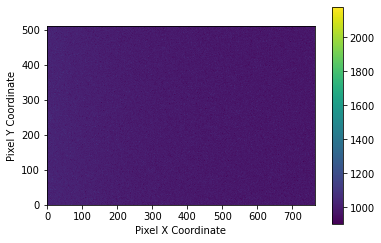

In [156]:
plt.imshow(data)
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

Simply showing the image isn't enough, we also need to scale it so that there is reasonable contrast within the image, and we'd like it to be big enough that we can see each pixel clearly.

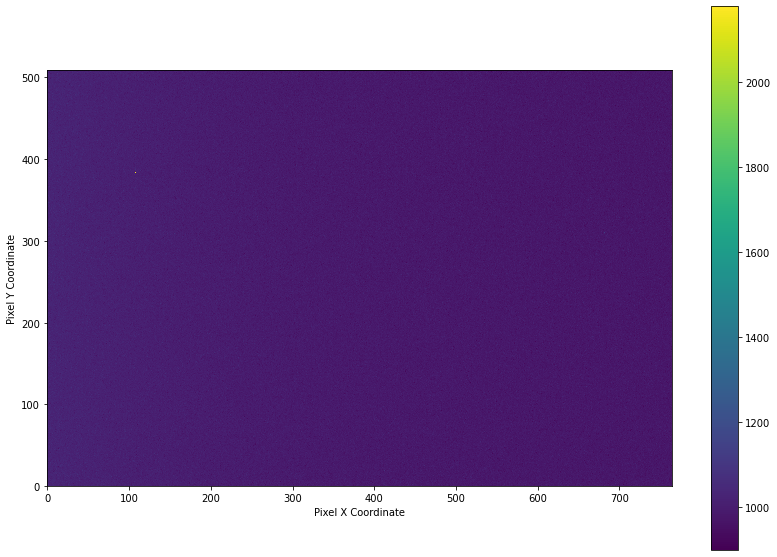

In [157]:
plt.figure(figsize=(14,10))
plt.imshow(data)
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

## Show an image with improved contrast

[Index](#Index)

The astropy visualization toolkit helps us improve the contrast by using a different data stretch.

In [158]:
from astropy import visualization

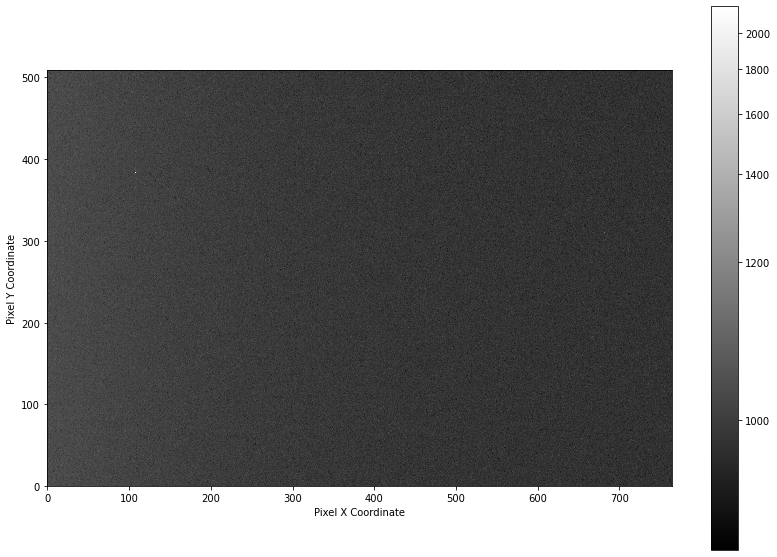

In [159]:
plt.figure(figsize=(14,10))
plt.imshow(data, norm=visualization.simple_norm(data, stretch='asinh'), cmap=plt.get_cmap('gray'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

There are two notable features in this image:
1. There is a gradient from left to right, with the left being brighter.
2. There is a hot pixel.  How can we identify it?

### Zooming in on a hot pixel

[Index](#Index)


Since it's the brightest pixel in the image, we can simply find the maximum value, and then find out where that maximum value is:

In [160]:
print("Brightest value:", data.max())
print("Location of brightest value:", data.argmax())

Brightest value: 2179
Location of brightest value: 293103


You'll note that the pixel number above is in the 100,000's, but our image is only 765x510 (numpy arrays use reverse-ordered indexing, so it is (y,x) instead of (x,y)):

In [161]:
data.shape

(510, 765)

In [162]:
import numpy as np

In [163]:
print("y,x coordinates of the brightest pixel:", np.unravel_index(data.argmax(), data.shape))

y,x coordinates of the brightest pixel: (383, 108)


Describe in your own words: what did `unravel_index` do?

'unravel_index' identified which set of coordinates in the image possessed the maximum value of the data by applying it to the data's shape, and then output the coordinates that have this value and thus possess the brightest pixel.

We can then "zoom in" to that part of the image by "slicing" out a chunk of the `data` array:

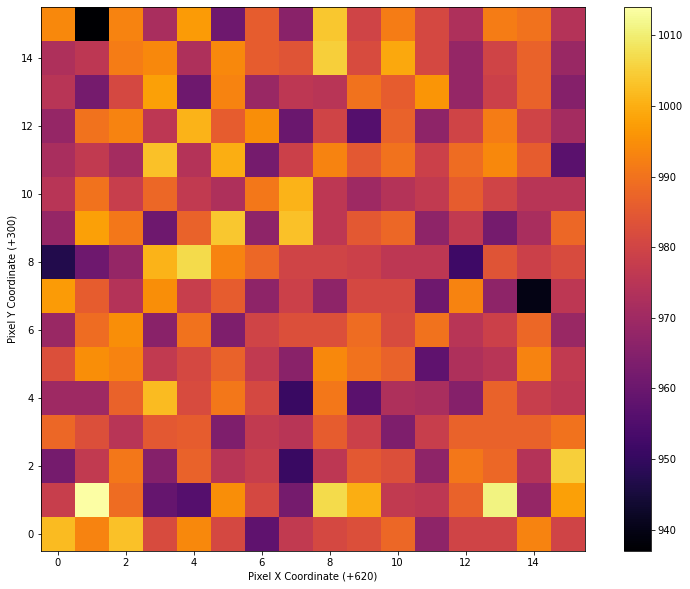

In [164]:
plt.figure(figsize=(14,10))
# we pick a "slice" from (y-8) to (y+8) and from (x-8) to (x+8)
plt.imshow(data[300:316, 620:636], cmap='inferno')
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate (+620)")
_=plt.ylabel("Pixel Y Coordinate (+300)")

### Examining Histograms

[Index](#Index)

We need to know something about the _distribution_ of pixel brightnesses beyond just where they are.  We can look at this distribution using a histogram.

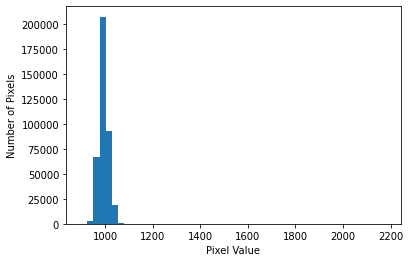

In [165]:
# the "ravel" method turns the 2D data image into a 1D list of values.
# we use it here because of the syntax requirements of the `hist` function
histresult = plt.hist(data.ravel(), bins=50)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

Note that the above histogram shows a broad range along the X-axis, but most of the pixels are in a narrow range.  The hot pixel is an _outlier_ from this distribution.

We can see this more clearly by log-scaling the histogram

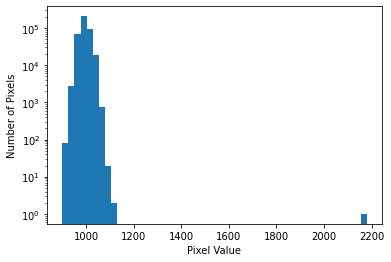

In [166]:
histresult = plt.hist(data.ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

We can re-make this histogram excluding the outlier using a "masking" approach.

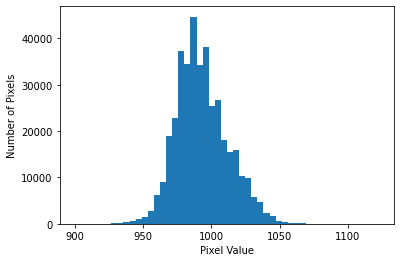

In [167]:
# first, we create a mask that excludes the bad data
# this is a "boolean array" of True and False values
# it will be True everywhere except on the one hot pixel, where it will be False
mask = data < 1800
# then, we re-histogram selecting the "good" data
histresult = plt.hist(data[mask].ravel(), bins=50)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

### Masking

[Index](#Index)

What did that line, `mask = data < 1800` do exactly?  It created a new array in which the number of pixels are the same as in ``data``, but now each pixel has a value of either True or False.

We can look at the mask, and see that it is mostly True (`True` will be yellow, `False` will be purple, by default).  You should be able to see one purple pixel at least:

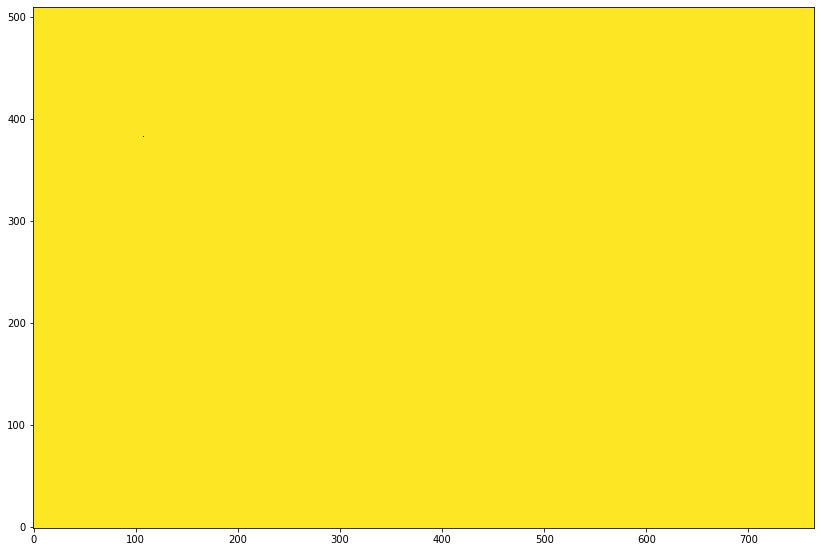

In [168]:
plt.figure(figsize=(14,14))
plt.imshow(mask)

When we index the data with `data[mask]`, we get back an array that includes the pixel value if the mask was `True` at that pixel, and does not include the pixel value if the mask was `False` at that pixel.

We can "invert the mask" and switch True to False and False to True with the `~` operator.  This lets us see the value of our outlier (in this case, there's only one):

In [169]:
data[~mask]

array([2179], dtype=uint16)

## Gaussian distribution

[Index](#Index)


Our bias image has a gradient in it, as you could see above, so its noise distribution does not look like a Gaussian.   Instead, it has a tail.  We can see this by over-plotting a Gaussian function with a reasonable estimate for the location parameters.

The Gaussian function is:

$$
f(x) = \frac{1}{\sigma \sqrt{2 \pi }} e^{-(x-x_0)^2 / (2 \sigma^2)}
$$

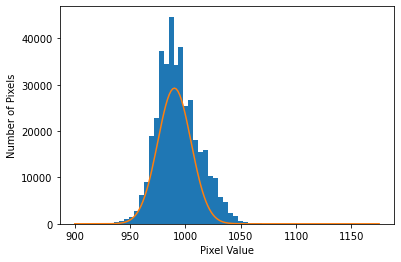

In [170]:
# this part repeats the histogram-making above
mask = data < 1800
histresult = plt.hist(data[mask].ravel(), bins=50)

#STUDENT NOTE: I changed some numbers to make the Gaussian fit my data more

# 'linspace' makes an array of (175) evenly-spaced points from the lower (1000) to upper (1175) value
x = np.linspace(900, 1175, 175)
sigma = 15 # I guessed this value by eye
x0 = 990 # I guessed this too
# compute the Gaussian function:
y = 1/(sigma*(2*np.pi)**0.5) * np.exp(-(x-x0)**2/(2*sigma**2))
scale = 1100000 # we need to multiply by a scale factor to see the curve; this number is arbitrary
plt.plot(x, y*scale)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

You can see from the above curve that there is something like a "skewed Gaussian" distribution in the data: the Gaussian curve fits most of the data, but there's a tail out to the right side.

Because of this tail, our noise estimates on the data won't be exactly right, but we can make them anyway.

### Noise Estimation

[Index](#Index)

We estimate the noise by taking the _standard deviation_ of the data.  If the bias were uniform, the standard deviation of our image would represent a measurement of the _read noise_ plus the intrinsic pixel-to-pixel variation.  If the pixel-to-pixel variation is small, the read noise would then be the only contributor to the measurement.

(`ddof` is the degrees of freedom.  This is a statistical correction for the fact that we're estimating the mean and the variation around the mean from the same data)

In [21]:
print("Estimated read noise + pixel-to-pixel variation (without accounting for gradient):", data[mask].std(ddof=1))

Estimated read noise + pixel-to-pixel variation (without accounting for gradient): 18.944628084257815


The `std` method gives us the standard deviation of the data, and it suggests that the noise is about 19 counts.

However, now we need to explore another way to estimate the readnoise.

We have many bias images.  We can combine them to obtain a direct estimate of the readnoise, independent of the pixel-to-pixel variation.

Each bias image is the same.  The only difference between the images will be read noise.  That means we can estimate the noise on a pixel-by-pixel basis, but by comparing each pixel to itself over many measurements.

We start by verifying that our bias images are all taken under the same conditions.  We can do this by looking at their FITS headers to make sure they have the same exposure time.

In [22]:
# the "glob" module lets us store the results of wildcard searches into python variables
import glob
bias_file_list = glob.glob("lab3_bias*FIT")
print("There are",len(bias_file_list),"bias images")
print(bias_file_list)

There are 10 bias images
['lab3_bias_0d04001.FIT', 'lab3_bias_0d04002.FIT', 'lab3_bias_0d04003.FIT', 'lab3_bias_0d04004.FIT', 'lab3_bias_0d04005.FIT', 'lab3_bias_0d04006.FIT', 'lab3_bias_0d04007.FIT', 'lab3_bias_0d04008.FIT', 'lab3_bias_0d04009.FIT', 'lab3_bias_0d04010.FIT']


We use `for` loops to loop over the entries in a list.  This example will print relevant information - the exposure time and CCD temperature - for each "bias" image.

In [23]:
for filename in bias_file_list:
    header = fits.getheader(filename)
    print(filename, header['EXPTIME'], header['CCD-TEMP'])

lab3_bias_0d04001.FIT 0.04 -0.231815405223
lab3_bias_0d04002.FIT 0.04 -0.231815405223
lab3_bias_0d04003.FIT 0.04 -0.231815405223
lab3_bias_0d04004.FIT 0.04 -0.231815405223
lab3_bias_0d04005.FIT 0.04 -0.231815405223
lab3_bias_0d04006.FIT 0.04 -0.231815405223
lab3_bias_0d04007.FIT 0.04 -0.231815405223
lab3_bias_0d04008.FIT 0.04 -0.231815405223
lab3_bias_0d04009.FIT 0.04 -0.231815405223
lab3_bias_0d04010.FIT 0.04 -0.231815405223


By inspecting the headers above, we see that we have 10 bias images to work with.

Note that these "bias" images are not strictly bias images; they are technically 0.04 second Dark frames.  In 0.04 seconds, we probably will not accrue much dark current, but there might be some small dark current contribution.

#### Header Loading Aside

[Index](#Index)

(aside: how do we inspect headers?  How did I know to use the `'EXPTIME'` keyword?  `fits.getheader` loads a header from a file.  In the cell below, load a header from any file and see what it looks like:)

In [24]:
# STUDENT ACTIVITY:
# Use `fits.getheader` to read the header from a .FIT file and show the header contents
header = fits.getheader('lab3_bias_0d04001.FIT')
print(filename, header['EXPTIME'], header['CCD-TEMP'])

lab3_bias_0d04010.FIT 0.04 -0.231815405223


Because these came from the same CCD, they all have the same dimensions.


## Multiple Exposures as a "Time Series" Data Cube

[Index](#Index)

We can therefore stack up their data into a "data cube" that will effectively be a time series: two dimensions are pixel dimensions (x, y), while the third (z) is time; we took each image at a different time, and that's the only thing that changed.

In [25]:
# the `fits.getdata` function loads data from a fits file
# np.array() converts an input to an array
# the "inline for loop" is the really important part here, though:
# we are loading one image for each file name in the bias_file_list we made above
bias_timeseries = np.array([fits.getdata(fn) for fn in bias_file_list])

In [26]:
print(bias_timeseries.shape)

(10, 510, 765)


The data structure `bias_timeseries` is now an array of ten images that are each the same size.

We can perform statistics along the time axis (the array is in `z,y,x` shape, so `z` is the time axis).  To see what this means, we can look at what the time series data looks like for a single pixel.

In the example below, we plot the time series for pixel x=150, y=100:

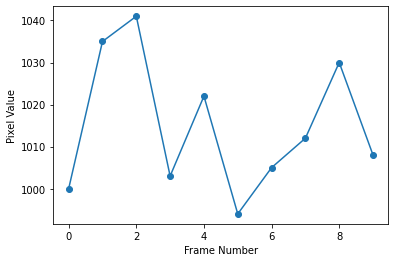

In [27]:
_=plt.plot(bias_timeseries[:,100,150], marker='o')
_=plt.xlabel("Frame Number")
_=plt.ylabel("Pixel Value")

We can take statistics of this pixel to see what the mean and standard deviation are:

In [28]:
print("Mean =",bias_timeseries[:,100,150].mean(), " Standard deviation =",bias_timeseries[:,100,150].std(ddof=1))

Mean = 1015.0  Standard deviation = 16.048537489614297


To repeat this measurement for _every_ pixel, we obtain the statistics along an axis:

In [29]:
bias_mean_image = bias_timeseries.mean(axis=0)
bias_std_image = bias_timeseries.std(axis=0, ddof=1)

Take a moment to appreciate the above line.  It just did a _lot_ of things all at once:

* it calculated the mean of 10 exposures for each of 765 * 510 = 390150 pixels
* it calculated the standard deviation of 10 exposures for each pixel
* it stored the results of each into an image array of the same shape as the inputs

This array arithmetic - doing the same operations on millions of pixels all at once - is at the heart of image analysis.  Computers can do this sort of thing very fast, and they have to.

We then inspect these as images, as before.  The mean image looks just like the original data image:

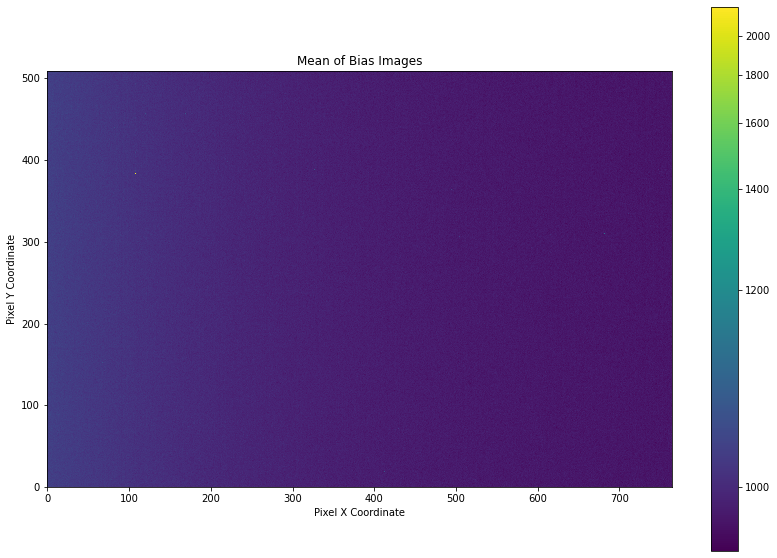

In [30]:
plt.figure(figsize=(14,10))
plt.imshow(bias_mean_image, norm=visualization.simple_norm(bias_mean_image, stretch='asinh'))
plt.colorbar()
_=plt.title("Mean of Bias Images")
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

However, the standard deviation image looks quite different: it's now nearly the same everywhere, the only thing left in the image is (read) noise:

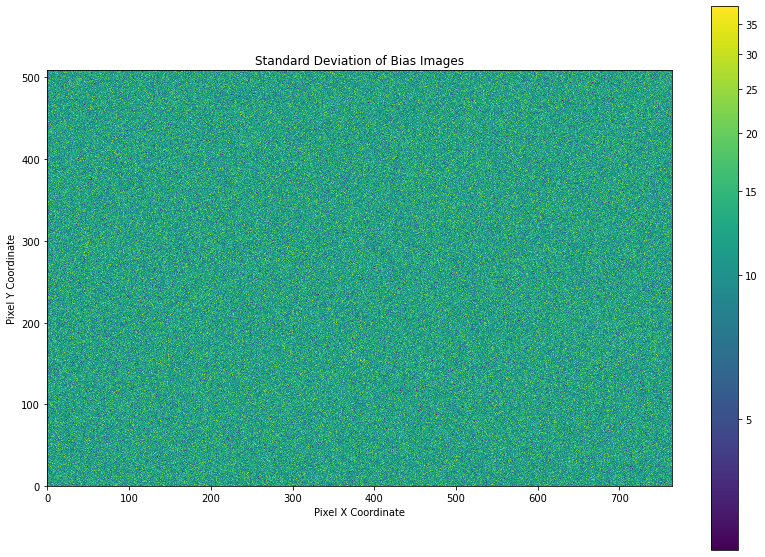

In [31]:
plt.figure(figsize=(14,10))
plt.imshow(bias_std_image, norm=visualization.simple_norm(bias_std_image, stretch='asinh'))
plt.colorbar()
_=plt.title("Standard Deviation of Bias Images")
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

Each value in the `bias_std_image` map is an independent measurement of the read noise from the detector.  Let's look at some values, including our x,y=150,100 and at the hot pixel:

In [32]:
print("Estimate of read noise at 150,100:",bias_std_image[100,150],"and at y,x=(308, 628)", bias_std_image[308,628])

Estimate of read noise at 150,100: 16.048537489614297 and at y,x=(308, 628) 10.606077922063786


## The mean of the mean

[Index](#Index)

To get the best estimate of the average read noise, we can take the average *over all pixels* of our standard deviation *measured across time samples*:

In [33]:
mean_readnoise = bias_std_image.mean()
print("The mean readnoise over all pixels =",mean_readnoise)

The mean readnoise over all pixels = 12.322344571786381


Similarly, we can compute the average bias (again, averaging over all pixels in the CCD):

In [34]:
mean_bias = bias_mean_image.mean()
print("mean bias =",mean_bias)

mean bias = 992.2534640522875


## Robust Statistics

[Index](#Index)


However, the distribution function shown above was a _skewed_ Gaussian, which means our estimate of the mean and standard deviation are biased.  To account for such issues, we can employ _robust statistics_ to obtain better estimates.  "Robust statistics" are statitical estimates that are robust against outliers, i.e., adding in a few outliers does not substantially affect the estimate.

One example robust estimator is the _median_, which is very good at approximating the _mean_:

In [35]:
median_bias = np.median(bias_mean_image)
print("Median bias level across the image =",median_bias)
median_readnoise = np.median(bias_std_image)
print("Median standard deviation level across the image =",median_readnoise)

Median bias level across the image = 987.9
Median standard deviation level across the image = 11.92616171839596


We can look at the histogram of the read noise estimates (`bias_std_image`).  In this case, they are very similar:

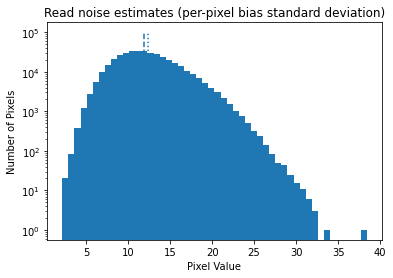

In [36]:
histresult = plt.hist(bias_std_image.ravel(), bins=50, log=True)
# plot a vertical line at the median, then at the mean
plt.vlines(median_readnoise, 1, 1e5, linestyle='--')
plt.vlines(mean_readnoise, 1, 1e5, linestyle=':')
plt.title("Read noise estimates (per-pixel bias standard deviation)")
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

For the bias value, the mean and median are quite different: the pixels are not "unimodel", they have a broad, non-Gaussian distribution.

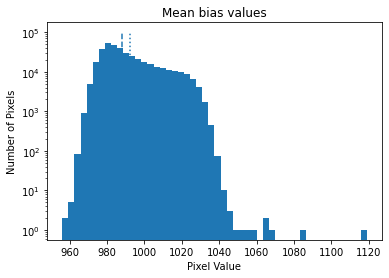

In [37]:
# we will re-make the mask we used to exclude outliers
mask = bias_mean_image < 1800
histresult = plt.hist(bias_mean_image[mask], bins=50, log=True)
# plot a vertical line at the median, then at the mean
plt.vlines(median_bias, 1, 1e5, linestyle='--')
plt.vlines(mean_bias, 1, 1e5, linestyle=':')
plt.title("Mean bias values")
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

# 2. Inspect an image: Dark Frame

[Index](#Index)

Next, we will look at our dark frames and see how they differ from the bias frames.

In [38]:
ls *dark*

 Volume in drive C is Local Disk
 Volume Serial Number is 8471-B1A1

 Directory of C:\Users\sophi\AST3722C

02/07/2022  10:17 PM         4,582,059 Lab3_CCD_Reductions_Bias_Dark_SophieClark.ipynb
01/26/2022  05:27 PM           786,240 lab3_dark_0d2001.FIT
01/26/2022  05:27 PM           786,240 lab3_dark_0d2002.FIT
01/26/2022  05:27 PM           786,240 lab3_dark_0d2003.FIT
01/26/2022  05:29 PM           786,240 lab3_dark_1001.FIT
01/26/2022  05:29 PM           786,240 lab3_dark_1002.FIT
01/26/2022  05:29 PM           786,240 lab3_dark_1003.FIT
01/26/2022  05:38 PM           786,240 lab3_dark_125001.FIT
01/26/2022  05:40 PM           786,240 lab3_dark_125002.FIT
01/26/2022  05:42 PM           786,240 lab3_dark_125003.FIT
01/26/2022  05:32 PM           786,240 lab3_dark_25001.FIT
01/26/2022  05:33 PM           786,240 lab3_dark_25002.FIT
01/26/2022  05:33 PM           786,240 lab3_dark_25003.FIT
01/26/2022  05:31 PM           786,240 lab3_dark_5001.FIT
01/26/2022  05:31 PM           786,2

In [39]:
# student entry here: first, load the data
# Start with the first 10s dark image

# STUDENT NOTE: We were not required to take 10s darks for this lab, so I used the 25s darks instead
dark_fn = 'lab3_dark_25001.FIT' # put a filename in the quotes
# then, load a FITS file's data as you've done above for the bias
dark_data = fits.getdata(dark_fn)

# note:your answers should be something like:
# dark_fn = 'some_fits_fits.fits'
# dark_data = some_function_to_get_fits_data(dark_fn)
# in other words, use the variable dark_fn

In the next cell, show the image as we did [above](#Show-an-image-with-improved-contrast) for the bias.

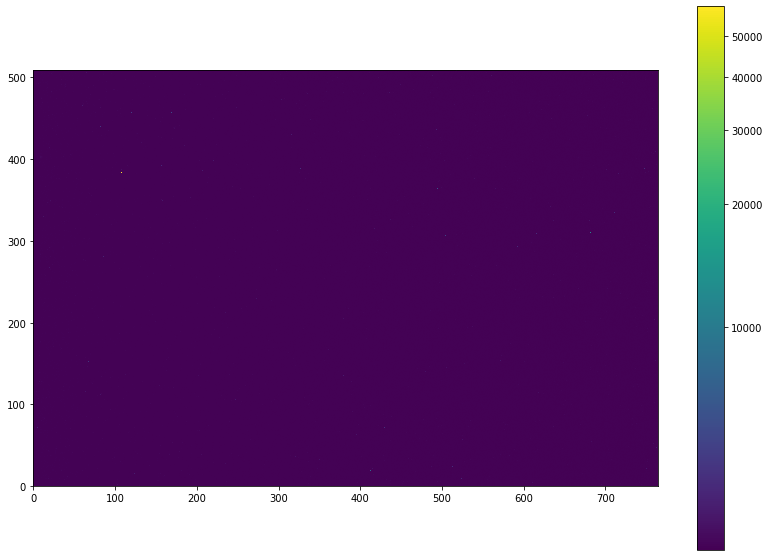

In [40]:
# student entry here
# then, display the data, just as with the bias above
plt.figure(figsize=(14,10))
plt.imshow(dark_data, norm=visualization.simple_norm(dark_data, stretch='asinh'))
plt.colorbar()

## Dark Frame Questions
[Index](#Index)

Use the code examples you saw above to answer these questions in the cells below

1. Is there a hot pixel?  Where is it?  
2. How long was the exposure?  Is the filename correct or misleading?
3. What is the average value in our dark frame?
4. What is the average dark current rate?  Note that you have to subtract the average bias to determine this.  You should use the _average_ dark current and _average_ bias for this.

In [171]:
# student exercise: find the hot pixel (again, as done above for the bias image)
print("Brightest value:", dark_data.max())
print("Location of brightest value:", dark_data.argmax())
print("y,x coordinates of the brightest pixel:", np.unravel_index(dark_data.argmax(), dark_data.shape))
print("Yes, there is a hot pixel at the coordinates listed above.")

Brightest value: 58920
Location of brightest value: 293103
y,x coordinates of the brightest pixel: (383, 108)
Yes, there is a hot pixel at the coordinates listed above.


In [172]:
# student exercise: find the exposure time from the FITS header
# reminder: delete the <s and >s
header = fits.getheader('lab3_dark_25001.FIT')
print('lab3_dark_25001.FIT', header['EXPTIME'], header['CCD-TEMP'])
print("The exposure time of lab3_dark_25001.FIT is", '25.0 seconds')
print("Thus, the file name was not correct or misleading, as long as you recognize the separation between 25 and 001.")

lab3_dark_25001.FIT 25.0 0.1890187278651
The exposure time of lab3_dark_25001.FIT is 25.0 seconds
Thus, the file name was not correct or misleading, as long as you recognize the separation between 25 and 001.


In [173]:
# student exercise: take the mean and median of the dark frame you loaded a minute ago
# (from above, the dark frame's data should be in the variable `dark_data`)
print(np.mean(dark_data))
print(np.median(dark_data))
print("Mean value =", '996.836124567474')
print("Median value =", '994.0')
print("The average value in our dark frames is 996.836124567474.")

996.836124567474
994.0
Mean value = 996.836124567474
Median value = 994.0
The average value in our dark frames is 996.836124567474.


## Dark Current Rate
[Index](#Index)

In the next cell, you'll estimate the _rate_ of dark current accumulation.

A rate is simply a number per time, so you need to calculate the number of dark counts and the exposure time.

Dividing them will get you the dark rate.

In [174]:
# student exercise: Determine the dark current and dark current rate
# the goal is to use the values computed above (the mean dark current and the mean bias)
# to obtain an estimate of the mean dark current and dark current rate
dark_counts = 996.836124567474 - mean_bias
dark_rate = dark_counts/25.0
print("Dark current counts =", str(dark_counts))
print("Dark rate (dark current / exposure time) =", str(dark_rate), "counts per second")
print("Thus, the average dark current rate (without bias) is about 0.18 counts per second.")

Dark current counts = 4.58266051518649
Dark rate (dark current / exposure time) = 0.18330642060745958 counts per second
Thus, the average dark current rate (without bias) is about 0.18 counts per second.


In the above exercise, you estimated the average dark current from the data.  However, we can do better by subtracting the bias pixel-by-pixel first.

Let's start by seeing what the bias-subtracted dark looks like.  As long as the images are the same `shape` (which is always true if they come from the same CCD), we can subtract them from one another.

The next several cells make images and guide you through some detailed image analysis.

In [45]:
# Subtract two images
# this means we will subtract each pixel's value in `bias_mean_image` from the corresponding value in `dark_data`
bias_subtracted_dark = dark_data - bias_mean_image

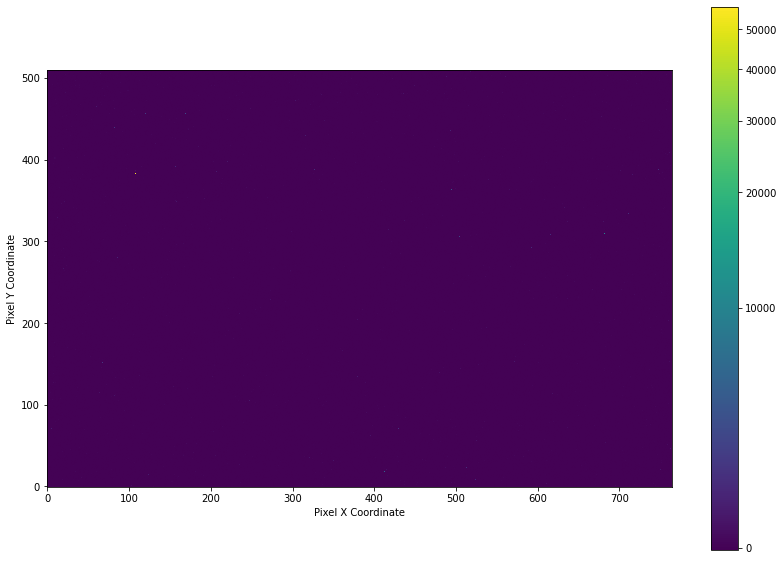

In [46]:
plt.figure(figsize=(14,10))
plt.imshow(bias_subtracted_dark, norm=visualization.simple_norm(bias_subtracted_dark, stretch='asinh'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

In the image above, we still have a pesky very bright outlier that is making our display look bad. 


To fix this, we need to know something about the _distribution_ of our data again

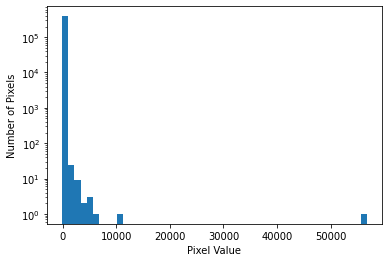

In [47]:
histresult = plt.hist(bias_subtracted_dark.ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

From the above plot, we can see that _almost_ all of the data are in the range [0,2000], but there's that one big outlier.  In fact, the vast majority of the data are below, say, 100.  Let's mask out the bad pixel and look closer.

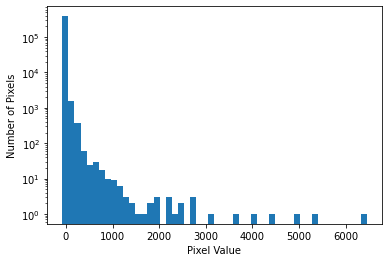

In [48]:
mask = bias_subtracted_dark < 8000
histresult = plt.hist(bias_subtracted_dark[mask].ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

This new histogram, excluding our dramatic outlier, shows us that almost all of the data are below 200 counts.  We have only about 10-20 outliers above 200 (recall that $10^0 = 1$).  So let's zoom in once more:

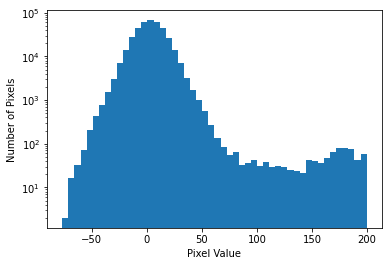

In [49]:
mask = bias_subtracted_dark < 200
histresult = plt.hist(bias_subtracted_dark[mask].ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

The above plot is a well-behaved, Gaussian-looking distribution with a small tail, which we can see if we plot it with a linear Y-axis again:

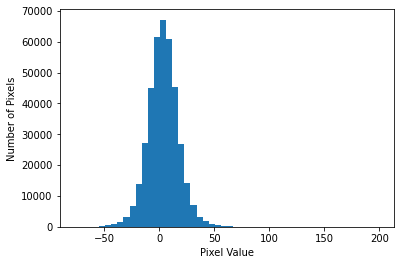

In [50]:
mask = bias_subtracted_dark < 200
histresult = plt.hist(bias_subtracted_dark[mask].ravel(), bins=50)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

We can now display the image with a more reasonable range of values.  I picked -30 to 50, as they're pretty close to the boundaries of where we expect to see any pixels: there are only a couple pixels above and below these values.

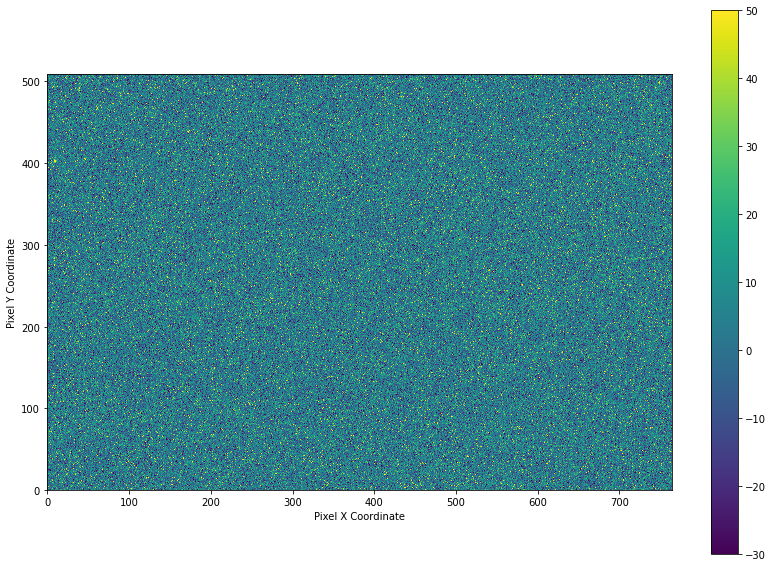

In [51]:
plt.figure(figsize=(14,10))
plt.imshow(bias_subtracted_dark, vmin=-30, vmax=50)
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

### Student Question: vmin, vmax
[Index](#Index)

What do the `imshow` arguments `vmin` and `vmax` do?

Answer: 'vmin' and 'vmax' instruct the plot what the minimum and maximum count values for the image need to be. For example, in the image above one can see that there is no data greater than the vmax value or less than the vmin value. 

Now we can see that the above image is a clean-looking noise frame.  There are a few outliers, but the mean value is constant across the image - there is no gradient.

Since we saw a gradient in the bias image, but we don't see one in the dark minus bias image, we can infer that the gradient is in the bias - in other words, it's intrinsic to our CCD and will always be there no matter how short an exposure we take.

## Bias-subtracted Dark Stats
[Index](#Index)

Now we can compute some statistics about this bias-subtracted dark image.  

What are the mean and median?

In [175]:
# student exercise: compute the mean and median of the bias-subtracted-dark
mean_bias_subtracted_dark = np.mean(bias_subtracted_dark)
median_bias_subtracted_dark = np.median(bias_subtracted_dark)
print("Mean bias_subtracted_dark =", str(mean_bias_subtracted_dark))
print("Median bias_subtracted_dark =", str(median_bias_subtracted_dark))

Mean bias_subtracted_dark = 4.5826605151864666
Median bias_subtracted_dark = 3.5


These values are an estimate of the dark current obtained in this exposure, but they're a little different from the estimate obtained taking the mean of the dark minus the mean of the bias.

What is the estimated dark current rate (counts per second) for these data?

In [176]:
# student exercise: What is the dark current rate estimated after bias subtraction?
rate_estimate = np.mean(bias_subtracted_dark)/25.0
print("Rate estimate =", str(rate_estimate))

Rate estimate = 0.18330642060745866


We can improve on this rate estimate by averaging over several dark images, like we did above with bias images.

In [54]:
dark_file_list = glob.glob("lab3_dark*FIT")
print("There are",len(dark_file_list),"dark images")
print(dark_file_list)
# I excluded the 0.04 darks we took in between the sets of longer exposures since these would correspond to the bias images

There are 15 dark images
['lab3_dark_0d2001.FIT', 'lab3_dark_0d2002.FIT', 'lab3_dark_0d2003.FIT', 'lab3_dark_1001.FIT', 'lab3_dark_1002.FIT', 'lab3_dark_1003.FIT', 'lab3_dark_125001.FIT', 'lab3_dark_125002.FIT', 'lab3_dark_125003.FIT', 'lab3_dark_25001.FIT', 'lab3_dark_25002.FIT', 'lab3_dark_25003.FIT', 'lab3_dark_5001.FIT', 'lab3_dark_5002.FIT', 'lab3_dark_5003.FIT']


In [55]:
for filename in dark_file_list:
    header = fits.getheader(filename)
    print(filename, header['EXPTIME'], header['CCD-TEMP'])

lab3_dark_0d2001.FIT 0.2 0.1890187278651
lab3_dark_0d2002.FIT 0.2 0.1890187278651
lab3_dark_0d2003.FIT 0.2 0.1890187278651
lab3_dark_1001.FIT 1.0 0.1890187278651
lab3_dark_1002.FIT 1.0 -0.231815405223
lab3_dark_1003.FIT 1.0 0.1890187278651
lab3_dark_125001.FIT 125.0 0.1890187278651
lab3_dark_125002.FIT 125.0 -0.231815405223
lab3_dark_125003.FIT 125.0 0.1890187278651
lab3_dark_25001.FIT 25.0 0.1890187278651
lab3_dark_25002.FIT 25.0 0.1890187278651
lab3_dark_25003.FIT 25.0 -0.231815405223
lab3_dark_5001.FIT 5.0 0.1890187278651
lab3_dark_5002.FIT 5.0 -0.231815405223
lab3_dark_5003.FIT 5.0 0.1890187278651


In [56]:
dark_timeseries = np.array([fits.getdata(fn) for fn in dark_file_list])
dark_timeseries.shape

(15, 510, 765)

We can again plot the dark values for some pixel:

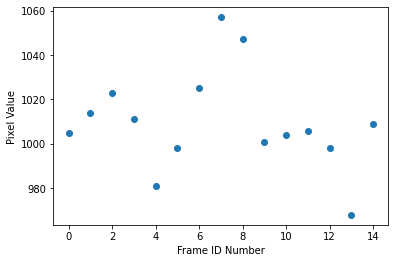

In [57]:
plt.plot(dark_timeseries[:,100,150], 'o')
_=plt.xlabel("Frame ID Number")
_=plt.ylabel("Pixel Value")

We calculate a noise image by taking the standard deviation in time:

In [58]:
dark_std = dark_timeseries.std(axis=0, ddof=1)
dark_mean = dark_timeseries.mean(axis=0)

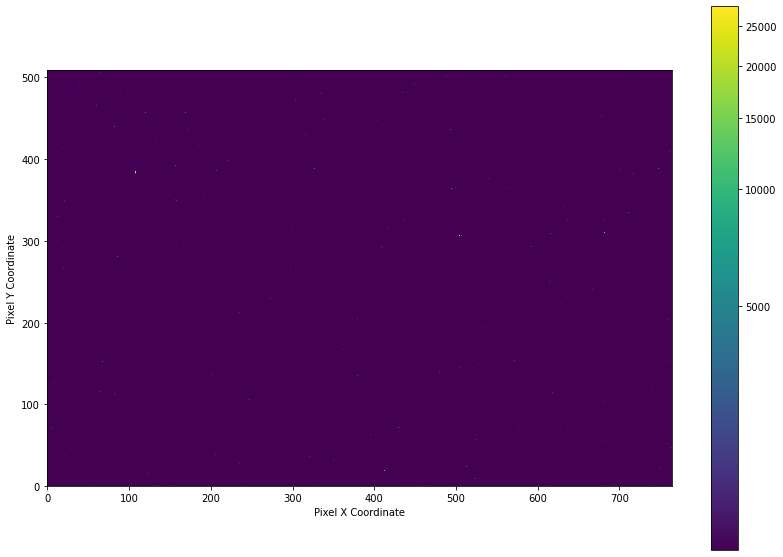

In [59]:
plt.figure(figsize=(14,10))
plt.imshow(dark_std, norm=visualization.simple_norm(dark_std, stretch='asinh'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

Our hot pixel is causing problems, so let's chop it out semi-automatically using a `percentile` cut.  By setting `max_percent=99.95` below, we set the brightest pixel in the displayed stretch to be just a little bit fainter than the brightest pixel.

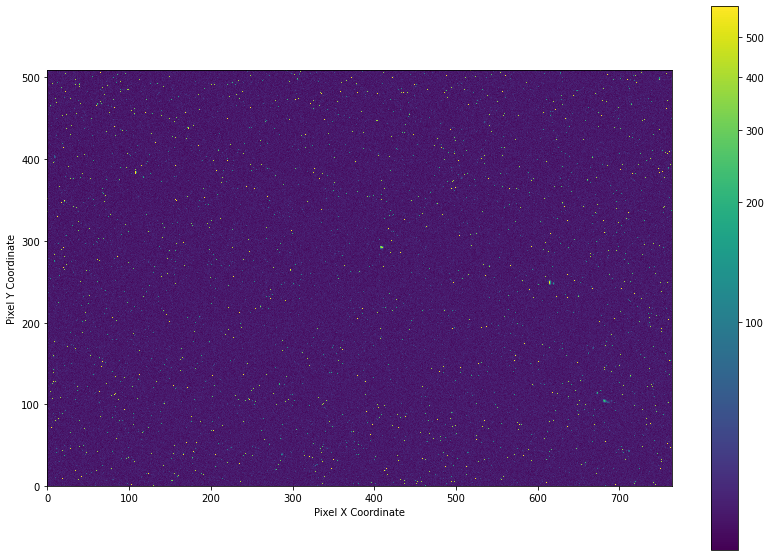

In [60]:
plt.figure(figsize=(14,10))
plt.imshow(dark_std, norm=visualization.simple_norm(dark_std, stretch='asinh', max_percent=99.95))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

### Noise estimate from dark stack
[Index](#Index)


So again we have an image that contains (almost) only noise, but this time it contains contributions from both read noise and from dark current.


What are the mean and median noise level in this image?

In [61]:
# student exercise
mean_dark_noise = np.mean(dark_std)
median_dark_noise = np.median(dark_std)

In [62]:
print("Mean dark noise:",mean_dark_noise)
print("Median dark noise:",median_dark_noise)

Mean dark noise: 19.501018730186388
Median dark noise: 17.09497280600631


Our estimate of the dark noise (from the dark frames) will be more precise than the readnoise estimate from the bias frames.  In the histogram below, the distribution will be narrower for the darks.

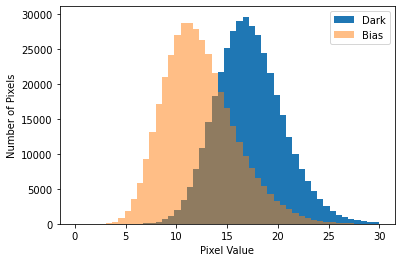

In [63]:
# comparison of the dark noise (note that this time we hand-specified the bin locations)
_ = plt.hist(dark_std.ravel(), bins=np.linspace(0,30), label='Dark')
_ = plt.hist(bias_std_image.ravel(), bins=np.linspace(0,30), label='Bias', alpha=0.5)
leg = plt.legend(loc='best')
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

In [64]:
print("Mean read noise:",mean_readnoise)
print("Median read noise:",median_readnoise)

Mean read noise: 12.322344571786381
Median read noise: 11.92616171839596


Now we can estimate how much _noise_ was added by the dark current.

We know that the dark current added (dark_mean - bias_mean_image) counts:

In [65]:
mean_dark_current = np.mean(dark_mean) - np.mean(bias_mean_image)
mean_dark_current

6.6963537101114525

What is the resulting dark rate?

In [66]:
# student exercise
dark_rate_estimate = mean_dark_current/25.0
dark_rate_estimate

0.2678541484044581

Given the dark rate you've estimated, let's assess whether the "bias" frames are really dark-electron-free.

How many dark current counts do you expect, on average, per pixel in the bias frames?

In [177]:
# student exercise
n_dark_counts = mean_dark_current/(510*765) #number of pixels based on the data shape
n_dark_counts

1.7163536358096763e-05

Based on that result, assess: Is the short "bias" exposure really a good estimate of the bias, or is it significantly affected by dark current?

Student answer:
Yes, there are very few dark current counts per pixel in the bias frames, so the short "bias" exposure does appear to be a good estimate of the bias that is not significantly altered by the dark current.

# 3. Gain

[Index](#Index)

During the lab, you took data on how the counts changed over time at fixed light level. You will now read in that data, and estimate the

In [68]:
#student exercise: load in the high light files
#STUDENT NOTE: We switched the purpose of the bright and light files so I used the light files here.
import glob
bright_file_list = glob.glob("lab3_light*FIT")
print("There are",len(bright_file_list),"bright images")
print(bright_file_list)

There are 27 bright images
['lab3_light_0d04001.FIT', 'lab3_light_0d04002.FIT', 'lab3_light_0d04003.FIT', 'lab3_light_0d1001.FIT', 'lab3_light_0d1002.FIT', 'lab3_light_0d1003.FIT', 'lab3_light_0d3001.FIT', 'lab3_light_0d3002.FIT', 'lab3_light_0d3003.FIT', 'lab3_light_100s001.FIT', 'lab3_light_100s002.FIT', 'lab3_light_100s003.FIT', 'lab3_light_10s001.FIT', 'lab3_light_10s002.FIT', 'lab3_light_10s003.FIT', 'lab3_light_1s001.FIT', 'lab3_light_1s002.FIT', 'lab3_light_1s003.FIT', 'lab3_light_30s001.FIT', 'lab3_light_30s002.FIT', 'lab3_light_30s003.FIT', 'lab3_light_3s001.FIT', 'lab3_light_3s002.FIT', 'lab3_light_3s003.FIT', 'lab3_light_60s001.FIT', 'lab3_light_60s002.FIT', 'lab3_light_60s003.FIT']


In [69]:
#student exercise: load in the low light files
import glob
faint_file_list = glob.glob("lab3_faint*FIT")
print("There are",len(faint_file_list),"faint images")
print(faint_file_list)

There are 24 faint images
['lab3_faint_0d04001.FIT', 'lab3_faint_0d04002.FIT', 'lab3_faint_0d04003.FIT', 'lab3_faint_0d1001.FIT', 'lab3_faint_0d1002.FIT', 'lab3_faint_0d1003.FIT', 'lab3_faint_0d3001.FIT', 'lab3_faint_0d3002.FIT', 'lab3_faint_0d3003.FIT', 'lab3_faint_100s001.FIT', 'lab3_faint_100s002.FIT', 'lab3_faint_100s003.FIT', 'lab3_faint_10s001.FIT', 'lab3_faint_10s002.FIT', 'lab3_faint_10s003.FIT', 'lab3_faint_1s001.FIT', 'lab3_faint_1s002.FIT', 'lab3_faint_1s003.FIT', 'lab3_faint_30s001.FIT', 'lab3_faint_30s002.FIT', 'lab3_faint_30s003.FIT', 'lab3_faint_3s001.FIT', 'lab3_faint_3s002.FIT', 'lab3_faint_3s003.FIT']


In [178]:
#student exercise: subtract the bias frame from each of the light files
for filename in bright_file_list:
    bright_file_data = fits.getdata(filename)
    bright_nobias_list = bright_file_data - bias_mean_image

In [179]:
#student exercise: subtract the dark current expected from each file, 
#taking into account the exposure time of the file

# STUDENT NOTE: I decided to remove both the bias and the dark current here as it was an easier process than doing two
# separate for loops
bright_subtracted_mean_list = []
for filename in bright_file_list:
    bright_file_data = fits.getdata(filename)
    header = fits.getheader(filename)
    exptime = header['EXPTIME']
    bright_nobias_nodark_list = bright_file_data - (mean_dark_current/exptime) - bias_mean_image
    print("Average count:", bright_nobias_nodark_list.mean())  
    bright_subtracted_mean_list.append(bright_nobias_nodark_list.mean())
#STUDENT NOTE: The files with extremely low exposure time (0.04, 0.2 s) resulted in negative values because these values
# would ordinarily be used to quantify bias or dark current

Average count: -162.00494168909282
Average count: -162.2442265795196
Average count: -161.59658080225444
Average count: -47.103726771754026
Average count: -47.966992182493485
Average count: -47.741453287196805
Average count: 44.28025118544168
Average count: 42.12048442906591
Average count: 41.79414327822649
Average count: 22685.90782308343
Average count: 23308.72461662438
Average count: 23801.717224595668
Average count: 2442.248562757914
Average count: 1908.9756395232603
Average count: 2406.0907901063697
Average count: 16.31305036524418
Average count: 232.5009447648341
Average count: 232.8650841983853
Average count: 7340.27335875945
Average count: 7231.185656593617
Average count: 6742.030690554914
Average count: 684.0986856337308
Average count: 714.973587594515
Average count: 719.1804516211714
Average count: 12364.786141125209
Average count: 13654.715927104957
Average count: 13525.976621709597


In [73]:
#calculate the average counts for each image (after the dark current and bias have been removed)
# STUDENT NOTE: SEE ABOVE; included in for loop because it was easier

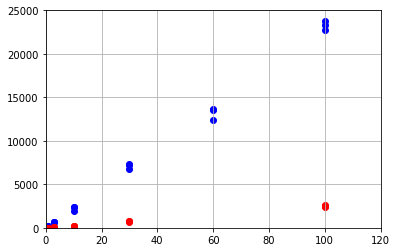

In [183]:
#plot the average counts versus time for both the high light and low light files
bright_exptime_list = []
bright_nobias_nodark_list = []
for filename in bright_file_list:
    bright_file_data = fits.getdata(filename)
    header = fits.getheader(filename)
    exptime = header['EXPTIME']
    bright_nobias_nodark = bright_file_data - (mean_dark_current/exptime) - bias_mean_image
    bright_nobias_nodark_mean = np.mean(bright_nobias_nodark)
    bright_exptime_list.append(exptime)  
    bright_nobias_nodark_list.append(bright_nobias_nodark_mean)
faint_exptime_list = []
faint_nobias_nodark_list = []
for filename in faint_file_list:
    faint_file_data = fits.getdata(filename)
    header = fits.getheader(filename)
    exptime = header['EXPTIME']
    faint_nobias_nodark = faint_file_data - (mean_dark_current/exptime) - bias_mean_image
    faint_nobias_nodark_mean = np.mean(faint_nobias_nodark)
    faint_exptime_list.append(exptime)  
    faint_nobias_nodark_list.append(faint_nobias_nodark_mean)
plt.scatter(bright_exptime_list, bright_nobias_nodark_list, color='blue')
plt.scatter(faint_exptime_list, faint_nobias_nodark_list, color='red')
plt.grid()
plt.xlim(0, 120)
plt.ylim(0, 25000)
plt.show()

Estimate the slope and intercept for each of these lines by eye (approximation is fine)

In [184]:
#estimate the slope and intercept for each line numerically, using something like
bright_light_fit=np.polyfit(bright_exptime_list, bright_nobias_nodark_list, 1.)
print("Bright light slope is", str(bright_light_fit[0]), "and intercept is", str(bright_light_fit[1]))
faint_light_fit=np.polyfit(faint_exptime_list, faint_nobias_nodark_list, 1)
print("Faint light slope is", str(faint_light_fit[0]), "and intercept is", str(faint_light_fit[1]))

Bright light slope is 230.684175362141 and intercept is -73.00431921523209
Faint light slope is 25.50690654037902 and intercept is -53.89739708588086


The one here represents the degrees of freedom, in this case 1 means linear (y=ax+b). 2 would be quadratic (y=ax$^2$+bx+c)

In [117]:
#calculate the line
x_high_line = np.linspace(0,100,10)
y_high_line = x_high_line * bright_light_fit[0] + bright_light_fit[1]
x_low_line = np.linspace(0, 100, 10)
y_low_line = x_low_line * faint_light_fit[0] + faint_light_fit[1]

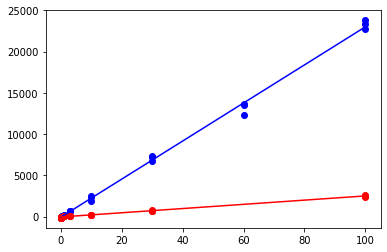

In [118]:
# make a plot that includes both the high and low light data, as well as the high and low light lines.
#Use different colors for the the two datasets
plt.plot(x_high_line, y_high_line, color='blue')
plt.plot(x_low_line, y_low_line, color='red')
plt.scatter(bright_exptime_list, bright_nobias_nodark_list, color='blue')
plt.scatter(faint_exptime_list, faint_nobias_nodark_list, color='red')

How does the gain vary with time? With saturation? With light level? How well does the data agree with your expectations? Is a line a good fit to the data?

Answer: Time and light level both greatly increase the gain, as visible by the clear difference in the slopes of the bright light files and the faint light files. The more saturated data (the bright light files) also has a significantly greater gain. These results are expected from the previous analysis as well as the clear differences between the two data types. This is further exemplified by how well the lines fit to the data, despite a couple slight outliers. 

# 4. Flat Fielding

[Index](#Index)

Flats (as they are known) are used to estimate how efficiently each pixel responds to light. During real observations, the are taken using either the uniformly illuminated sky at twilight ('sky flats') or by pointing the telescope at a white surface illuminated uniformly by a lamp ('dome flats'). To construct a flat, this uniformly illuminated, bright but not saturated image (similar to your long exposures) has the bias and dark current subtracted. Many flats in the same filter may be averaged together to construct an average flat for that filter. The value of each pixel in the flat is divided by the mean value of the whole flat (so that the average value of each pixel is one). The target images are then divided by the normalized average flat of the correct filter to remove pixel-to-pixel sensitivity variations.

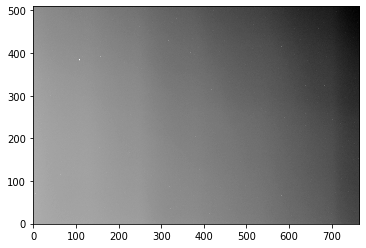

In [149]:
#choose one of your longer duration evenly illuminated exposures that is not saturated to be your flat and read it in
# for real data, you'll want to average several similar exposures together to reduce noise, 
# but we won't worry about that for now
flat_data = fits.getdata('lab3_light_100s001.FIT')
plt.imshow(flat_data, norm=visualization.simple_norm(data, stretch='asinh'), cmap=plt.get_cmap('gray'))
# all of our illuminated data was compromised by the classroom lights (causing the light in the left side of the image)
# but for the purpose of this lab this image will be effective.

In [126]:
# calculate the average pixel value for the whole image
flat_data_mean = np.mean(flat_data)

In [128]:
#divide every pixel in the image by this average value
flat_data_even = flat_data/flat_data_mean

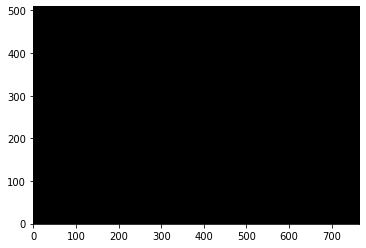

In [147]:
#save your flat with a new but relevant file name
hdu = fits.PrimaryHDU(flat_data_even)
hdu.writeto('lab3_flat_data_even_100s01.FIT')
new_data = fits.getdata('lab3_flat_data_even_100s01.FIT')
plt.imshow(new_data, norm=visualization.simple_norm(data, stretch='asinh'), cmap=plt.get_cmap('gray'))

In a few sentences- a paragraph, discuss how this lab went. What did you learn? Were there parts that were more or less challenging? Now that you've analyzed your data, would you have done anything differently in the data collection? Do you have recommendations to future students? 

Answer: This lab was challenging but extremely helpful to my understanding of the processing of CCD data and FITS files. Creating the for loops to process the bright and faint file data in order to plot it was particularly challenging because I had a small error in my code that I had to work through, which was tedious but overall a great experience to learn from for my future coding. I gained much more understanding of how FITS data is stored, which helped me to understand how to work with it in performing numerical procedures with this type of data in order to create new images. If I were to repeat this lab, I would focus much more on getting uniformly illuminated images, as this would have improved the data I received and analyzed. I would recommend to future students to understand every step of the code as much as you can, as focusing on understanding why each step is important will be extremely helpful in future data processing. 

# Index (end)


 * [#1. Inspect Biases](#1.-Inspect-an-image:-Bias) - mostly guided work, you will run cells & read
   * [Show an image with improved contrast](#Show-an-image-with-improved-contrast)
   * [Zoom in on a hot pixel](#Zooming-in-on-a-hot-pixel) student exercise
   * [Examining Histograms](#Examining-Histograms)
   * [Masking](#Masking)
   * [Gaussian Distribution](#Gaussian-distribution)
   * [Noise Estimation](#Noise-Estimation)
   * [Header Loading](#Header-Loading-Aside) student exercise
   * [Multiple Exposures -> Time Series Cube](#Multiple-Exposures-as-a-"Time-Series"-Data-Cube)
   * [Mean of the Mean](#The-mean-of-the-mean)
   * [Robust Statistics](#Robust-Statistics)
 * [#2. Inspect Darks](#2.-Inspect-an-image:-Dark-Frame) - student work: you fill in the blanks
   * [Dark Frame Questions](#Dark-Frame-Questions)
   * [Dark Current Rate](#Dark-Current-Rate)
   * [vmin, vmax](#Student-Question:-vmin,-vmax)
   * [Bias-subtracted dark statistics](#Bias-subtracted-Dark-Stats)
   * [Noise estimate from dark stack](#Noise-estimate-from-dark-stack)
 * [#3. Gain](#3.-Gain)
 * [#4. Flat-Fielding](#4.-Flat-Fielding)